# Baseline

##Что такое baseline?

**Бейзлайн (от анг. baseline - базовая линия)** - основная простая модель, которая может служить ориентиром для дальнейшей работы и оценки качества. На хакатонах такие модели обычно служат отправной точкой для написания своего кода.

Также бейзлайны позволяют понять, какой итоговый результат должна давать модель. Например, в нашем случае это файл для отправки на платформу.


##Как работать с бейзлайном?

1) Запустите бейзлайн, получите ответ и отправьте его на плфторму проведения, чтобы посмотреть на изначальные результаты работы, а также обозначить себя на лидерборде.




2) Внимательно познакомьтесь с данными, поищите дополнительную информацию в интернете на тему данных, разберитесь в признаках и теме.




3) Попробуйте улучшить предобработку данных: сделайте визуализации, ставьте и проверяйте гипотезы. Для проверки ваших гипотез отправляйте результат на платформу и следите за изменением вашего места на турнирной таблице.




4) Подумайте о том, какими инструментами лучше решить представленную задачу машинного обучения. В нашем случае это задача бинарной классификации.

##Код бейзлайна.

Сначала выполним импорт всех необходимых библиотек.

In [913]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import math

In [914]:
warnings.filterwarnings("ignore")

Здесь мы открываем файлы из папки data: данные для обучения модели и для предсказания.

In [1001]:
model = pd.read_csv('train-2.csv')
check = pd.read_csv('predict.csv')

In [1004]:
len(model.loc[model.Vmag < 0])

28

In [975]:
le = LabelEncoder()
label = le.fit_transform(model['SpType'])
sorted(set(label))[-1]

1841

In [977]:
model['TargetClass'].value_counts()

0    15842
1    15799
Name: TargetClass, dtype: int64

In [976]:
model.drop("SpType", axis=1, inplace=True)
model["SpType"] = label

In [978]:
model.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'Amag', 'TargetClass', 'SpType'], dtype='object')

In [979]:
model.Amag = model.Amag.apply(lambda x: math.ceil(x))
model.Vmag = model.Vmag.apply(lambda x: math.ceil(x))
model.Plx = model.Plx.apply(lambda x: math.ceil(x))
model.e_Plx = model.e_Plx.apply(lambda x: math.ceil(x))
model["B-V"] = model["B-V"].apply(lambda x: math.ceil(x))

In [980]:
# model["BVtype"] = round(model["B-V"] * model.SpType)

In [981]:
model = model.drop(["e_Plx", "Plx", "Vmag", "Amag", "B-V"], axis=1)

Делим наши данные на train и test. Не забываем, что нам нужно предсказать является ли звезда гигантом или карликом.

In [982]:
y = model['TargetClass']
X = model.drop(columns=['TargetClass'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

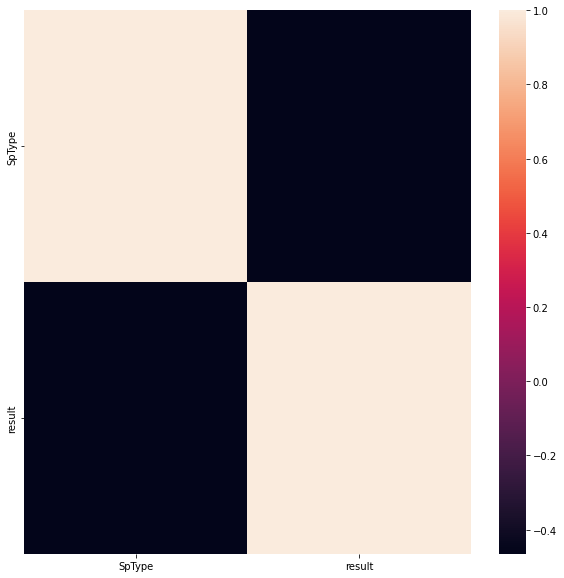

In [983]:
fig = plt.figure(figsize = (10, 10))
X_test2 = X_test
X_test2["result"] = y_test
data_ploting = X_test2.corr(method= 'pearson')
sns.heatmap(data_ploting, linecolor='black')
plt.show()

    Модель, выбранная в бейзлайне - случайный лес. Она не является оптимальной, но быстро обучается и позволяет получить результат, который выше случайного. Можете начать улучшать бейзлайлн с того, что попробовать изменить гиперпараметры представленного случайного леса.

In [984]:
%%time
xgb = XGBClassifier(n_estimators=300)
xgb.fit(X_train, y_train)

CPU times: user 4.47 s, sys: 2.14 s, total: 6.61 s
Wall time: 1.23 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [985]:
X_test = X_test.drop("result", axis=1)

In [986]:
pred = xgb.predict(X_test)

Здесь мы оцениваем то, насколько точно работает наша модель. Здесь мы смотрим на ROC-AUC метрику.

In [987]:
roc_auc_score(y_test, pred)

0.9813534488039111

Далее мы обращаемся к данным, для которых нам необходимо сделать предсказание и применить модель.

In [988]:
check.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7911 entries, 0 to 7910
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Vmag    7911 non-null   float64
 1   Plx     7911 non-null   float64
 2   e_Plx   7911 non-null   float64
 3   B-V     7911 non-null   float64
 4   SpType  7911 non-null   object 
 5   Amag    7911 non-null   float64
dtypes: float64(5), object(1)
memory usage: 371.0+ KB


Применяем разработанную модель к нашим данным, но до этого необходимо преобразоват признак "SpType".

In [989]:
label = le.fit_transform(check['SpType'])
label

array([ 620, 1027,  231, ...,  709,  560,  931])

In [990]:
check.drop("SpType", axis=1, inplace=True)
check["SpType"] = label

In [991]:
check

,Vmag,Plx,e_Plx,B-V,Amag,SpType
0,4.039519,13.596504,0.845101,-0.097823,15.774122,620
1,6.655719,4.010332,1.050017,1.386670,15.344976,1027
2,6.405060,0.348855,0.961598,0.951503,12.236103,231
3,9.113068,2.954461,1.251422,1.002819,15.560838,931
4,6.107686,3.144180,0.475795,0.493345,12.771981,839
...,...,...,...,...,...,...
7906,8.255272,2.858885,0.822289,1.349195,16.438014,1075
7907,6.255358,3.034436,0.449386,0.966053,13.898403,888
7908,8.643598,10.932145,0.947897,0.504383,18.980729,709
7909,9.400810,6.279361,1.332124,0.351073,16.872491,560


In [992]:
pred = check[['SpType']]

In [993]:
pred = xgb.predict(pred)

Сохарняем результат в таком формате, чтобы его затем можно было бы вывести как CSV файл и выгружаем итоговый результат.

In [994]:
pred = pd.Series(pred)

In [995]:
pred.head(10)

0    1
1    1
2    1
3    0
4    1
5    1
6    0
7    1
8    0
9    1
dtype: int64

In [963]:
pred.to_csv('Result.csv')
pred_file = pd.read_csv('Result.csv')
pred_file.head(10)

,Unnamed: 0,0
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1
5,5,1
6,6,0
7,7,1
8,8,0
9,9,1


In [964]:
pred_file.rename(columns={'0': 'TargetClass','Unnamed: 0':'Number'}, inplace=True)

In [965]:
pred_file.head(10)

,Number,TargetClass
0,0,1
1,1,1
2,2,1
3,3,0
4,4,1
5,5,1
6,6,0
7,7,1
8,8,0
9,9,1


Удалим ненужные столбцы.

In [966]:
check=check.join(pred_file)

In [967]:
check.head()

,Vmag,Plx,e_Plx,B-V,Amag,SpType,Number,TargetClass
0,4.039519,13.596504,0.845101,-0.097823,15.774122,620,0,1
1,6.655719,4.010332,1.050017,1.386670,15.344976,1027,1,1
2,6.405060,0.348855,0.961598,0.951503,12.236103,231,2,1
3,9.113068,2.954461,1.251422,1.002819,15.560838,931,3,0
4,6.107686,3.144180,0.475795,0.493345,12.771981,839,4,1


In [968]:
pred_final = check.drop(['Number'], axis='columns')

Выполним проверку.

In [969]:
pred_final.head(10)

,Vmag,Plx,e_Plx,B-V,Amag,SpType,TargetClass
0,4.039519,13.596504,0.845101,-0.097823,15.774122,620,1
1,6.655719,4.010332,1.050017,1.386670,15.344976,1027,1
2,6.405060,0.348855,0.961598,0.951503,12.236103,231,1
3,9.113068,2.954461,1.251422,1.002819,15.560838,931,0
4,6.107686,3.144180,0.475795,0.493345,12.771981,839,1
5,7.337771,12.254347,0.651041,0.330493,17.315567,595,1
6,7.316560,0.662464,0.720464,-0.056743,12.845317,351,0
7,7.379830,4.494505,0.594863,1.322639,15.528721,969,1
8,9.284617,7.392761,1.116969,0.629743,19.626463,757,0
9,8.646860,4.137044,1.239575,0.371263,17.284021,643,1


И сохраним результат в итоговый файл.

In [970]:
pred_final.to_csv('Result_final.csv',index=False)

Желаем вам успехов в НТО!

In [971]:
# рассчитываем ROC AUC
auc1 = roc_auc_score(y_test, pred)
print('ROC AUC=%.3f' % (auc1))

ValueError: Found input variables with inconsistent numbers of samples: [9493, 7911]

In [972]:
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

ValueError: Found input variables with inconsistent numbers of samples: [9493, 7911]

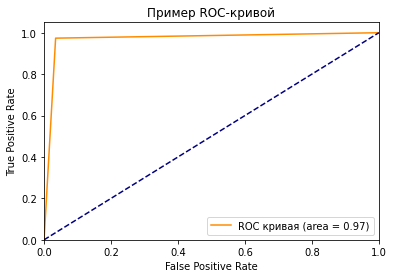

In [973]:
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()

In [996]:
need_to_predict = pd.read_csv("predict.csv")

In [997]:
need_to_predict

,Vmag,Plx,e_Plx,B-V,SpType,Amag
0,4.039519,13.596504,0.845101,-0.097823,F5V+...,15.774122
1,6.655719,4.010332,1.050017,1.386670,K5III,15.344976
2,6.405060,0.348855,0.961598,0.951503,B0IVpe,12.236103
3,9.113068,2.954461,1.251422,1.002819,K1III,15.560838
4,6.107686,3.144180,0.475795,0.493345,G8II-IIIvar,12.771981
...,...,...,...,...,...,...
7906,8.255272,2.858885,0.822289,1.349195,M3III,16.438014
7907,6.255358,3.034436,0.449386,0.966053,K0III,13.898403
7908,8.643598,10.932145,0.947897,0.504383,G0V,18.980729
7909,9.400810,6.279361,1.332124,0.351073,F2V,16.872491


In [998]:
le = LabelEncoder()
label = le.fit_transform(need_to_predict['SpType'])
need_to_predict.drop("SpType", axis=1, inplace=True)
need_to_predict["SpType"] = label

In [999]:
need_to_predict

,Vmag,Plx,e_Plx,B-V,Amag,SpType
0,4.039519,13.596504,0.845101,-0.097823,15.774122,620
1,6.655719,4.010332,1.050017,1.386670,15.344976,1027
2,6.405060,0.348855,0.961598,0.951503,12.236103,231
3,9.113068,2.954461,1.251422,1.002819,15.560838,931
4,6.107686,3.144180,0.475795,0.493345,12.771981,839
...,...,...,...,...,...,...
7906,8.255272,2.858885,0.822289,1.349195,16.438014,1075
7907,6.255358,3.034436,0.449386,0.966053,13.898403,888
7908,8.643598,10.932145,0.947897,0.504383,18.980729,709
7909,9.400810,6.279361,1.332124,0.351073,16.872491,560
